<a href="https://colab.research.google.com/github/tumble-weed/GANs/blob/master/cycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Converting Summer to Winter Using CycleGAN

In [0]:
!pip install -I --no-cache-dir pillow

     |████████████████████████████████| 2.0MB 3.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.


Download the Data (summer2winter yosemite images)

In [0]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
!unzip -n summer2winter-yosemite.zip

--2019-05-06 12:40:05--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.178.21
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.178.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133783376 (128M) [application/zip]
Saving to: ‘summer2winter-yosemite.zip.3’

summer2winter-yosem 100%[===================>] 127.58M  70.7MB/s    in 1.8s    

2019-05-06 12:40:07 (70.7 MB/s) - ‘summer2winter-yosemite.zip.3’ saved [133783376/133783376]

Archive:  summer2winter-yosemite.zip


In [0]:
import torch
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
matplotlib.rcParams['axes.grid'] = False
import torchvision
import warnings
import tqdm
is_cuda = torch.cuda.is_available()
tensor_to_numpy = lambda t: t.detach().cpu().numpy()
from termcolor import colored

To generate separate dataloaders for summer and winter imagesets

In [0]:
def make_data_loader(domain_name,
                    image_dir='summer2winter_yosemite',
                    image_size=128,
                    batch_size=16,
                    num_workers=0):
    transform = torchvision.transforms.Compose([torchvision.transforms.Resize((image_size,
                                                                              image_size)),
                                               torchvision.transforms.ToTensor()])
    
    image_path = image_dir
    train_path = os.path.join(image_path,domain_name)
    test_path = os.path.join(image_path,'test_{}'.format(domain_name))
    
    train_data = torchvision.datasets.ImageFolder(train_path,
                                                 transform)
    test_data = torchvision.datasets.ImageFolder(test_path,
                                                transform)
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                              batch_size = batch_size,
                                              shuffle=True,
                                              num_workers = num_workers)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size = batch_size,
                                              shuffle=False,
                                              num_workers = num_workers)
    return train_loader,test_loader

In [0]:
loader_summer, loader_test_summer = make_data_loader(domain_name='summer')
loader_winter,loader_test_winter = make_data_loader(domain_name ='winter')

Some Images from Summer and Winter

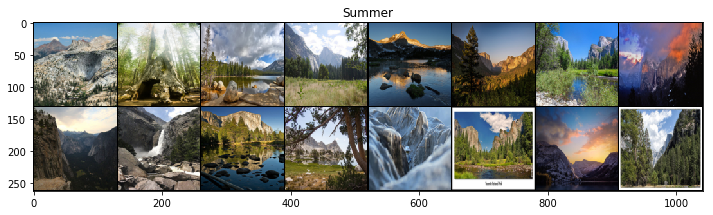

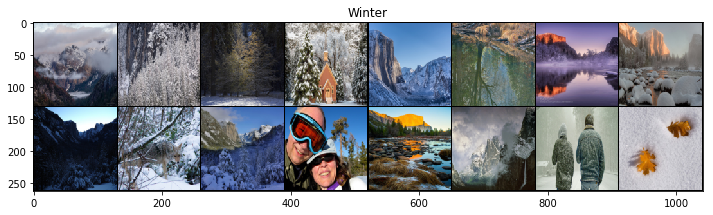

In [0]:
iter_summer = iter(loader_summer)
im_summer,_ = iter_summer.next()

plt.figure(figsize=(12,8))
plt.imshow(np.transpose(torchvision.utils.make_grid(im_summer),(1,2,0)))
plt.title('Summer')
plt.show()

iter_winter = iter(loader_winter)
im_winter,_ = iter_winter.next()

plt.figure(figsize=(12,8))
plt.imshow(np.transpose(torchvision.utils.make_grid(im_winter),(1,2,0)))
plt.title('Winter')
plt.show()



In [0]:

# def scale_t(t,rng = (-1,1)):
#     ''' scale images to 0 1 '''
#     mx,mn = rng
# #     tmx,tmn = t.max(),t.min()
#     return t*(mx-mn) + mn
# def descale_t(t,rng=(-1,1)):
#     ''' scale images to a custom range, default (-1,1) '''
#     mx,mn=rng
#     return (t - mn)/(mx-mn)
# img = im_summer[0]
# print('image ranges: ', img.max(),img.min())

# scaled_img = scale_t(img)
# print(scaled_img.max(),
#      scaled_img.min())

# descaled_img = descale_t(scaled_img)
# print(descaled_img.max(),
#      descaled_img.min())


In [0]:
def im_to_tanh(im):
    return 2*(im - 0.5)
def tanh_to_im(t):
    return (t + 1)/2.
    
img = im_summer[0]
print('image ranges: ', img.max(),img.min())

scaled_img = im_to_tanh(img)
print(scaled_img.max(),
     scaled_img.min())

descaled_tanh = tanh_to_im(scaled_img)
print(descaled_tanh.max(),
     descaled_tanh.min())


image ranges:  tensor(0.9333) tensor(0.0627)
tensor(0.8667) tensor(-0.8745)
tensor(0.9333) tensor(0.0627)


Define the Discriminator

In [0]:
class Discriminator(torch.nn.Module):
    def __init__(self,layer_info):
        super(Discriminator,self).__init__()
        layers = []
        in_channels = 3
        for l in layer_info:
            
            c = torch.nn.Conv2d(in_channels,
                                l['out_channels'],
                                l['kernel_size'],
                                stride=l['stride'],
                                padding=l['padding'],
                               bias=False)
            
            layers.append(c)
            
            if l['batch_norm']:
                b = torch.nn.BatchNorm2d(l['out_channels'])
                layers.append(b)
            r = torch.nn.ReLU()
            layers.append(r)
            
            in_channels = l['out_channels']
        clf = torch.nn.Conv2d(in_channels,1,4,stride=1,bias = False) # reference code has padding as 1
        layers.append(clf)
        r = torch.nn.ReLU()
        layers.append(r)
        self.layers = torch.nn.ModuleList(layers)
        
    def forward(self,x):
        for l in self.layers:
            x = l(x)
#         x = self.layers[-1](x)
        return x

D_info = [{'out_channels':64,
          'kernel_size':4,
          'stride':2,
          'padding':1,
          'batch_norm':False},
          
          {'out_channels':128,
          'kernel_size':4,
          'stride':2,
          'padding':1,
          'batch_norm':True},
          
          {'out_channels':256,
          'kernel_size':4,
          'stride':2,
          'padding':1,
          'batch_norm':True},

          {'out_channels':512,
          'kernel_size':4,
          'stride':2,
          'padding':1,
          'batch_norm':True},

#           {'out_channels':512,
#           'kernel_size':4,
#           'stride':2,
#           'padding':1,
#           'batch_norm':True},

         ]
if True:
    D = Discriminator(D_info)
    v = torch.randn(5,3,128,128)
    if is_cuda:
        D.cuda()
        v = v.cuda()
    print(D(v).shape)

torch.Size([5, 1, 5, 5])


Define a Residual Block (to be used by the Generator)

In [0]:
class ResBlock(torch.nn.Module):
    def __init__(self,resblock_info):
        super(ResBlock,self).__init__()
        layers = []
        for i in range(2):
            c = torch.nn.Conv2d(resblock_info['channels'],
                               resblock_info['channels'],
                               resblock_info['kernel_size'],
                               stride = resblock_info['stride'],
                               padding = resblock_info['padding'],
                               bias = False)
            b = torch.nn.BatchNorm2d(resblock_info['channels'])
            layers.append(c)
            layers.append(b)
        layers = torch.nn.ModuleList(layers)
        self.layers = layers
        
    def forward(self,x):
        c,b = self.layers[:2]
        y = torch.nn.functional.relu(b(c(x)))
        c,b = self.layers[2:]
        y = x + b(c(y))
        return y
if True:
    r = ResBlock({'type':'res_block',
          'channels':256,
          'kernel_size':3,
          'stride':1,
          'padding':1})
    print(r)
    

ResBlock(
  (layers): ModuleList(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


Reference code from facebook for checking

Our Generator

In [0]:
class CycleGenerator(torch.nn.Module):
    def __init__(self,layer_info):
        super(CycleGenerator,
             self).__init__()
        in_channels = 3
        layers = []
        for l in layer_info:
            if l['type'] == 'conv':
                c = torch.nn.Conv2d(in_channels,l['out_channels'],l['kernel_size'],
                                    stride=l['stride'],
                                    padding=l['padding'],
                                   bias=False)
                layers.append(c)
                if l['batch_norm']:
                    b = torch.nn.BatchNorm2d(l['out_channels'])
                    layers.append(b)
                r = torch.nn.ReLU()
                in_channels = l['out_channels']
            elif l['type'] == 'res_block':
                r = ResBlock(l)
                layers.append(r)
                in_channels = l['channels']
            elif l['type'] == 'deconv':
                d = torch.nn.ConvTranspose2d(in_channels,
                                            l['out_channels'],
                                            l['kernel_size'],
                                            stride = l['stride'],
                                            padding = l['padding'],
                                            bias = False)
                layers.append(d)
                if l['batch_norm']:
                    b = torch.nn.BatchNorm2d(l['out_channels'])
                    layers.append(b)
                r = torch.nn.ReLU()
                in_channels = l['out_channels']
        self.layers = torch.nn.ModuleList(layers)
    def forward(self,x):
        for l in self.layers:
            x = l(x)       
        out = torch.nn.functional.tanh(x)
        return out

G_info = [{'type':'conv',
          'out_channels':64,
          'kernel_size':4,
          'stride':2,
          'padding':1,
          'batch_norm':True},
          
          {'type':'conv',
          'out_channels':128,
          'kernel_size':4,
          'stride':2,
          'padding':1,
          'batch_norm':True},
          
          {'type':'conv',
          'out_channels':256,
          'kernel_size':4,
          'stride':2,
          'padding':1,
          'batch_norm':True},          
          
         ] +\
         [{'type':'res_block',
          'channels':256,
          'kernel_size':3,
          'stride':1,
          'padding':1}] * 6 +\
        [ {'type':'deconv',
          'out_channels':128,
          'kernel_size':4,
          'stride':2,
          'padding':1,
          'batch_norm':True},
         
        {'type':'deconv',
          'out_channels':64,
          'kernel_size':4,
          'stride':2,
          'padding':1,
          'batch_norm':True},
        
        {'type':'deconv',
          'out_channels':3,
          'kernel_size':4,
          'stride':2,
          'padding':1,
          'batch_norm':False},         
        ]
if False:
    G = CycleGenerator(G_info)
    v = torch.randn(5,3,128,128)
    if is_cuda:
        G.cuda()
        v = v.cuda()
    print(G(v).shape)
    

create all models

In [0]:
def create_all_models(D_info,
                      G_info,
                     ):
   
    G_summer_to_winter = CycleGenerator(G_info)
    D_winter = Discriminator(D_info)
    
    G_winter_to_summer = CycleGenerator(G_info)
    D_summer = Discriminator(D_info)
    
    
    models = (G_summer_to_winter,
    D_summer,
    G_winter_to_summer,
    D_winter)
    
    for m in models:
        if is_cuda:
            m.cuda()
    return models



G_summer_to_winter,D_summer,G_winter_to_summer,D_winter = create_all_models(D_info,
                      G_info,
                     )
print(G_summer_to_winter, G_winter_to_summer, D_summer, D_winter)

CycleGenerator(
  (layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ResBlock(
      (layers): ModuleList(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )

Make Optimizers

In [0]:
G_params  = list(G_summer_to_winter.parameters()) + list(G_winter_to_summer.parameters())
D_summer_params,D_winter_params = D_summer.parameters(),D_winter.parameters()
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_G = torch.optim.Adam(G_params,lr,[beta1,beta2])
opt_D_summer = torch.optim.Adam(D_summer_params,lr,[beta1,beta2])
opt_D_winter = torch.optim.Adam(D_winter_params,lr,[beta1,beta2])

Training Loop

In [0]:
def viz(model,
       true,
       name = None):
    
    model_training = model.training
    if model_training:
        model.eval()
    if is_cuda:
        true = true.cuda()

    fake = model(im_to_tanh(true)).detach().cpu()
    fake = tanh_to_im(fake)
    true = true.cpu()
    
    grid_fake = np.transpose(torchvision.utils.make_grid(fake),(1,2,0))
    grid_true = np.transpose(torchvision.utils.make_grid(true),(1,2,0))
    sample_summer = np.concatenate([grid_true,grid_fake],0)



    plt.figure(figsize=(12,8))
    plt.title(name)
    plt.imshow(sample_summer)
    plt.show()

    if model_training:
        model.train()


In [0]:
nepochs = 100
vis_every = 1
trends = {'loss_D_summer':[],
         'loss_D_winter':[],
         'loss_G':[],}
if not 'sanity check: summer to summer':
    loader_winter = loader_summer
# print(colored('Trying simple l2 loss for the generators','red','on_white')) 
print(colored('Only keeping the cycle loss','red','on_white'))
for e in tqdm.tqdm_notebook(range(nepochs)):
    for bix,((b_smr,_),
             (b_wtr,_)) in enumerate(tqdm.tqdm_notebook(zip(loader_summer,loader_winter))):
        
        if is_cuda:
            b_smr = b_smr.cuda();b_wtr= b_wtr.cuda()
            
        b_smr = im_to_tanh(b_smr);b_wtr = im_to_tanh(b_wtr)
        ''' Pass real through D, generate fakes, pass fakes through D'''
        D_of_smr = D_summer(b_smr);D_of_wtr = D_winter(b_wtr)
        fake_wtr = G_summer_to_winter(b_smr);fake_smr = G_winter_to_summer(b_wtr)
        D_of_fake_smr = D_summer(fake_smr); D_of_fake_wtr = D_winter(fake_wtr)
        
        ''' Losses for D'''
        loss_D_summer = torch.nn.functional.mse_loss(D_of_smr,torch.ones_like(D_of_smr)) + torch.nn.functional.mse_loss(D_of_fake_smr,torch.zeros_like(D_of_fake_smr))
        loss_D_winter = torch.nn.functional.mse_loss(D_of_wtr,torch.ones_like(D_of_wtr)) + torch.nn.functional.mse_loss(D_of_fake_wtr,torch.zeros_like(D_of_fake_wtr))
        
        ''' Optimize D parameters '''
        opt_D_summer.zero_grad();opt_D_winter.zero_grad()
        loss_D_summer.backward();loss_D_winter.backward()
        opt_D_winter.step();opt_D_summer.step();
        
        ''' Losses for G: reconstruction, fooling '''
        fake_wtr = G_summer_to_winter(b_smr);fake_smr = G_winter_to_summer(b_wtr)
        D_of_fake_smr = D_summer(fake_smr); D_of_fake_wtr = D_winter(fake_wtr)
        reconstructed_summer = G_winter_to_summer(fake_wtr);reconstructed_winter = G_summer_to_winter(fake_smr)
        loss_fool_summer = torch.nn.functional.mse_loss(D_of_fake_smr,torch.ones_like(D_of_fake_smr));loss_fool_winter = torch.nn.functional.mse_loss(D_of_fake_wtr,torch.ones_like(D_of_fake_wtr))
        cycle_loss_summer = torch.nn.functional.mse_loss(reconstructed_summer,b_smr);cycle_loss_winter = torch.nn.functional.mse_loss(reconstructed_winter,b_wtr)
        
        loss_G =  loss_fool_winter + loss_fool_summer + cycle_loss_summer + cycle_loss_winter      
#         loss_G =  cycle_loss_summer + cycle_loss_winter      
#         loss_G = torch.nn.functional.mse_loss(fake_wtr,b_smr) + torch.nn.functional.mse_loss(fake_smr,b_wtr)
        ''' Optimize G parameters '''
        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()
#         break
    '''visualization'''
    if e%vis_every == 0:
        trends['loss_D_summer'].append(tensor_to_numpy(loss_D_summer))
        trends['loss_D_winter'].append(tensor_to_numpy(loss_D_winter))
        trends['loss_G'].append(tensor_to_numpy(loss_G))

        plt.figure()
        plt.title('losses')
        plt.plot(trends['loss_D_summer'],label='loss_D_summer',c='r')
        plt.plot(trends['loss_D_winter'],label='loss_D_winter',c='g')
        plt.plot(trends['loss_G'],label='loss_G',c='b')
        plt.legend()
        plt.show()
        
        if False:
            '''
            G_summer_to_winter.eval();G_winter_to_summer.eval()

            fake_winter,fake_summer = G_summer_to_winter(im_to_tanh(im_summer)).detach(), G_summer_to_winter(im_to_tanh(im_winter)).detach()
            fake_winter,fake_summer = tanh_to_im(fake_winter), tanh_to_im(fake_summer)
            grid_fake_winter, grid_fake_summer = np.transpose(torchvision.utils.make_grid(fake_winter),(1,2,0)), np.transpose(torchvision.utils.make_grid(fake_summer),(1,2,0))
            grid_winter,grid_summer = np.transpose(torchvision.utils.make_grid(im_winter),(1,2,0)), np.transpose(torchvision.utils.make_grid(im_summer),(1,2,0))
            sample_summer,sample_winter = np.concatenate([grid_summer,grid_fake_summer],0), np.concatenate([grid_winter,grid_fake_winter],0)



            plt.figure(figsize=(12,8))
            plt.title('fake X')
            plt.imshow(sample_summer)
            plt.show()

            plt.figure(figsize=(12,8))
            plt.title('fake Y')
            plt.imshow(sample_winter)
            plt.show()
            G_summer_to_winter.train();G_winter_to_summer.train()
            '''
        
        viz(G_summer_to_winter,im_summer,name = 'to winter')
        viz(G_winter_to_summer,im_winter,name = 'to summer')        
        
        pass
    
    pass
